In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Data Science Eugene Pinsky/Homework_9/NVDA_with_labels.csv")
df.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label
0,2017-01-03 00:00:00-05:00,2017,1,3,Tuesday,1,2017-01,26.10,26.59,24.84,25.50,150199600,25.15,0.000000,25.150000,25.150000,undefined
1,2017-01-04 00:00:00-05:00,2017,1,4,Wednesday,1,2017-01,25.85,26.38,25.38,26.10,119922000,25.74,0.023331,25.445000,25.445000,undefined
2,2017-01-05 00:00:00-05:00,2017,1,5,Thursday,1,2017-01,26.13,26.45,25.26,25.43,98429600,25.09,-0.025385,25.326667,25.326667,undefined
3,2017-01-06 00:00:00-05:00,2017,1,6,Friday,1,2017-01,25.71,26.06,25.30,25.77,82285600,25.42,0.013367,25.350000,25.350000,undefined
4,2017-01-09 00:00:00-05:00,2017,1,9,Monday,2,2017-02,25.88,27.00,25.88,26.82,91624800,26.45,0.040543,25.570000,25.570000,undefined


## Q1.

Data preparation and preprocessing.

In [ ]:
#Preparing data

#getting year 1 data
year_1_df = df[df["Year"] == 2020]

#getting test data
test_data = year_1_df[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_1_df[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0
train_data["Quad_model_pred"] = 0
train_data["Cubic_model_pred"] = 0

train_data.shape

(53, 5)

In [ ]:
test_data.shape

(53, 2)

function to label weeks.

In [ ]:
def label_weeks(df,model_pred_column,label_column):
  
  for index,row in df.iterrows():

    if index == 0:
      continue
    
    elif df[model_pred_column][index] > df[model_pred_column][index - 1]:
      df[label_column][index] = "green"

    elif df[model_pred_column][index] < df[model_pred_column][index - 1]:
      df[label_column][index] = "red"
    
    elif df[model_pred_column][index] == df[model_pred_column][index - 1]:
      df[label_column][index] = df[label_column][index-1]

In [ ]:
#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Linear","Quadratic","Cubic"]) 

for window_size in range(5,13):
  for i,j in enumerate(range(window_size+1,len(train_data))):

    #getting previous W (window_size) values to train polynomial functions
    lin_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],1)

    quad_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],2)

    cube_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],3)

    #storing predicted values in column for predicted values of each polynomial function.
    train_data["Linear_model_pred"][j] = np.polyval(lin_coef,train_data["Week_Number"][j])

    train_data["Quad_model_pred"][j] = np.polyval(quad_coef,train_data["Week_Number"][j]) 
    
    train_data["Cubic_model_pred"][j] = np.polyval(cube_coef,train_data["Week_Number"][j]) 

  train_data["Label_1"] = ""
  train_data["Label_2"] = ""
  train_data["Label_3"] = ""
  
  train_data_temp = train_data.iloc[window_size+1:]
  train_data_temp = train_data_temp.reset_index(drop=True)

  label_weeks(train_data_temp,"Linear_model_pred","Label_1")
  label_weeks(train_data_temp,"Quad_model_pred","Label_2")
  label_weeks(train_data_temp,"Cubic_model_pred","Label_3")

  y_pred = train_data_temp["Label_1"].iloc[1:]
  y_true = test_data["Label"].iloc[window_size+2:]

  lin_result = accuracy_score(y_true,y_pred)

  y_pred = train_data_temp["Label_2"].iloc[1:]
  quad_result = accuracy_score(y_true,y_pred)

  y_pred = train_data_temp["Label_3"].iloc[1:]
  cube_result = accuracy_score(y_true,y_pred)

  results_df = results_df.append({"W":window_size,"Linear":lin_result,"Quadratic":quad_result,"Cubic":cube_result},ignore_index=True)

In [ ]:
results_df.head(8)

,W,Linear,Quadratic,Cubic
0,5.0,0.500000,0.543478,0.586957
1,6.0,0.533333,0.533333,0.577778
2,7.0,0.568182,0.568182,0.613636
3,8.0,0.604651,0.534884,0.651163
4,9.0,0.547619,0.500000,0.571429
5,10.0,0.634146,0.487805,0.560976
6,11.0,0.625000,0.575000,0.475000
7,12.0,0.589744,0.564103,0.512821


Plotting results

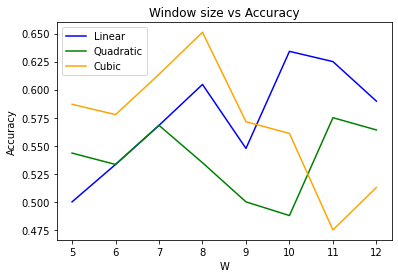

In [ ]:
plt.plot(results_df["W"],results_df["Linear"],color="blue")
plt.plot(results_df["W"],results_df["Quadratic"],color="green")
plt.plot(results_df["W"],results_df["Cubic"],color="orange")
plt.title("Window size vs Accuracy")
plt.xlabel("W")
plt.ylabel("Accuracy")
plt.legend(["Linear","Quadratic","Cubic"])

## Q2.

Linear (degree 1)

In [ ]:
#Preparing data

#getting year 1 data
year_2_data = df[df["Year"] == 2021]

#getting test data
test_data = year_2_data[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_2_data[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0

train_data.shape

(52, 3)

In [ ]:
#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Linear"]) 

window_size = 10

for i,j in enumerate(range(window_size+1,len(train_data))):

  #getting previous W (window_size) values to train polynomial functions
  lin_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],1)

  #storing predicted values in column for predicted values of each polynomial function.
  train_data["Linear_model_pred"][j] = np.polyval(lin_coef,train_data["Week_Number"][j])


train_data["Label_1"] = ""

train_data_temp = train_data.iloc[window_size+1:]
train_data_temp = train_data_temp.reset_index(drop=True)

label_weeks(train_data_temp,"Linear_model_pred","Label_1")

y_pred = train_data_temp["Label_1"].iloc[1:]
y_true = test_data["Label"].iloc[window_size+2:]

lin_result = round(accuracy_score(y_true,y_pred)*100,2)
lin_conf_mat = confusion_matrix(y_true,y_pred)

results_df = results_df.append({"W":window_size,"Linear":lin_result},ignore_index=True)

In [ ]:
results_df.head()

,W,Linear
0,10.0,30.0


Quadratic (degree 2)

In [ ]:
#Preparing data

#getting year 1 data
year_2_data = df[df["Year"] == 2021]

#getting test data
test_data = year_2_data[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_2_data[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0
train_data["Quad_model_pred"] = 0
train_data["Cubic_model_pred"] = 0

train_data.shape

(52, 5)

In [ ]:
#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Quadratic"]) 

window_size = 7

for i,j in enumerate(range(window_size+1,len(train_data))):

  #getting previous W (window_size) values to train polynomial functions
  quad_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],2)

  #storing predicted values in column for predicted values of each polynomial function.

  train_data["Quad_model_pred"][j] = np.polyval(quad_coef,train_data["Week_Number"][j]) 
  
train_data["Label_1"] = ""

train_data_temp = train_data.iloc[window_size+1:]
train_data_temp = train_data_temp.reset_index(drop=True)

label_weeks(train_data_temp,"Quad_model_pred","Label_1")

y_pred = train_data_temp["Label_1"].iloc[1:]
y_true = test_data["Label"].iloc[window_size+2:]

quad_result = round(accuracy_score(y_true,y_pred)*100,2)
quad_conf_mat = confusion_matrix(y_true,y_pred)

results_df = results_df.append({"W":window_size,"Quadratic":quad_result},ignore_index=True)

In [ ]:
results_df.head()

,W,Quadratic
0,7.0,60.47


Cubic(degree 3)

In [ ]:
#Preparing data

#getting year 1 data
year_2_data = df[df["Year"] == 2021]

#getting test data
test_data = year_2_data[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_2_data[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0
train_data["Quad_model_pred"] = 0
train_data["Cubic_model_pred"] = 0

In [ ]:
#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Cubic"]) 

window_size = 8

for i,j in enumerate(range(window_size+1,len(train_data))):

  #getting previous W (window_size) values to train polynomial functions

  cube_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],3)

  #storing predicted values in column for predicted values of each polynomial function.
  train_data["Cubic_model_pred"][j] = np.polyval(cube_coef,train_data["Week_Number"][j]) 

train_data["Label_1"] = ""

train_data_temp = train_data.iloc[window_size+1:]
train_data_temp = train_data_temp.reset_index(drop=True)

label_weeks(train_data_temp,"Cubic_model_pred","Label_1")

y_pred = train_data_temp["Label_1"].iloc[1:]
y_true = test_data["Label"].iloc[window_size+2:]

cube_result = round(accuracy_score(y_true,y_pred)*100,2)
cube_conf_mat = confusion_matrix(y_true,y_pred)

results_df = results_df.append({"W":window_size,"Cubic":cube_result},ignore_index=True)

In [ ]:
results_df.head()

,W,Cubic
0,8.0,52.38


## Q3.

Linear

In [ ]:
lin_conf_mat

array([[ 7, 11],
       [17,  5]])

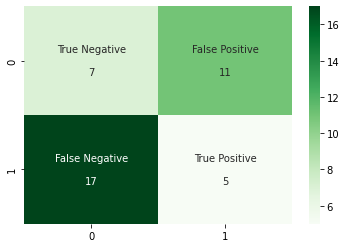

In [ ]:
#labels for each section as the group name and counts each group has
group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in lin_conf_mat.flatten()]

labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lin_conf_mat, annot=labels, fmt="", cmap='Greens')

Quadratic

In [ ]:
quad_conf_mat

array([[13,  8],
       [ 9, 13]])

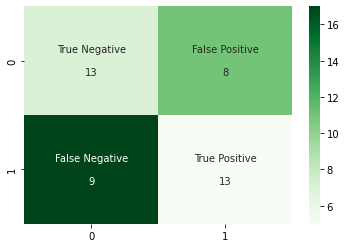

In [ ]:
group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in quad_conf_mat.flatten()]
labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lin_conf_mat, annot=labels, fmt="", cmap='Greens')

Cubic

In [ ]:
cube_conf_mat

array([[11,  9],
       [11, 11]])

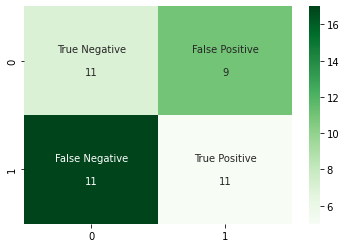

In [ ]:
group_names = ["True Negative","False Positive","False Negative","True Positive"]
group_counts = ["{0:0.0f}".format(value) for value in cube_conf_mat.flatten()]
labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(lin_conf_mat, annot=labels, fmt="",cmap="Greens")

## Q4.

Buy with labels trading strategy

In [242]:
#function to carry out buy with label weekly trading strategy
def buy_with_labels(df,end):

  #cash amount initially used to invest in stock market
  initial_cash = 100

  #quantity of shares bought at opening price
  shares_bought = 0

  #amount gained by selling stock at adjusted closing price
  amount_gained = 0

  #value achieved from selling stocks at closing price at the end of given period.
  capital = 0 

  #boolean variable to determine if . 
  invested = False

  #iterating through dataframe
  for index,row in df.iterrows():
 
   #Finding first green week or green week after a red week ,and we dont have a position in market yet.
    if df["Label"][index] == "green" and invested ==False :
      
      #buying shares equal to the amount of cash we hold currently 
      shares_bought = initial_cash / df["Open"][index]
      
      #as we have bought shares equal in evaluation to our cash initial cash = 0
      initial_cash = 0

      #we have a position in the market
      invested = True

    #Finding red week where we dont have a position
    elif df["Label"][index] == "red" and invested ==False :
      
      #we do nothing
      continue

    #conditions if we have put money in the market

    #check to see we are not at the last day of trading.
    if index!= end:

      #if next week is red and current week is green
      if invested == True and df["Label"][index] == "green" and df["Label"][index+1] == "red":

        #selling stock at adjusted closing price at the end of the week
        initial_cash += df["Adj Close"][index] * shares_bought
        
        #all shares are sold
        shares_bought = 0
        
        #we are no longer invested in the market.
        invested = False

      #if current week is green and (next week/next day) is green 
      elif invested == True and df["Label"][index] == "green" and df["Label"][index+1] == "green":

        #do nothing
        continue

    #if we end our trading period while being invested in the market
    if index == end and invested == True:
        
        #selling stock at adjusted closing price at the end of the week
        initial_cash += df["Adj Close"][index] * shares_bought
        
        #all shares are sold
        shares_bought = 0

        #we are no longer invested in the market.
        invested = False
  
  #returning the updated cash
  return initial_cash

Linear model

In [256]:
#Preparing data

#getting year 1 data
year_2_data = df[df["Year"] == 2021]

#getting test data
test_data = year_2_data[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_2_data[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0


#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Linear"]) 

window_size = 10

for i,j in enumerate(range(window_size+1,len(train_data))):

  #getting previous W (window_size) values to train polynomial functions
  lin_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],1)

  #storing predicted values in column for predicted values of each polynomial function.
  train_data["Linear_model_pred"][j] = np.polyval(lin_coef,train_data["Week_Number"][j])


train_data["Label_1"] = ""

train_data_temp = train_data.iloc[window_size+1:]
train_data_temp = train_data_temp.reset_index(drop=True)

label_weeks(train_data_temp,"Linear_model_pred","Label_1")

y_pred = train_data_temp["Label_1"].iloc[1:]
y_true = test_data["Label"].iloc[window_size+2:]

lin_result = round(accuracy_score(y_true,y_pred)*100,2)
lin_conf_mat = confusion_matrix(y_true,y_pred)

results_df = results_df.append({"W":window_size,"Linear":lin_result},ignore_index=True)


In [260]:
year_2_data = year_2_data.drop(columns=["Label"])
year_2_data = year_2_data[year_2_data["Week_Number"] > window_size+2 ]
year_2_data = year_2_data.reset_index(drop=True)
year_2_data.head()

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA
0,2021-03-29 00:00:00-04:00,2021,3,29,Monday,13,2021-13,128.20,130.62,127.00,129.48,27352000,129.33,0.008489,129.080714,134.6188
1,2021-03-30 00:00:00-04:00,2021,3,30,Tuesday,13,2021-13,128.42,129.75,127.05,128.72,20020400,128.56,-0.005908,129.368571,134.6220
2,2021-03-31 00:00:00-04:00,2021,3,31,Wednesday,13,2021-13,130.15,134.71,129.82,133.48,31477600,133.32,0.037019,129.621429,134.6874
3,2021-04-01 00:00:00-04:00,2021,4,1,Thursday,13,2021-13,135.72,138.70,135.11,138.12,30827600,137.95,0.034724,130.303571,134.7774
4,2021-04-05 00:00:00-04:00,2021,4,5,Monday,14,2021-14,138.68,140.14,137.33,139.88,25567200,139.71,0.012725,130.872143,134.8024


In [264]:
year_2_data = pd.merge(year_2_data,test_data.iloc[window_size+2:])

,Date,Year,Month,Day,Weekday,Week_Number,Year_Week,Open,High,Low,Close,Volume,Adj Close,Return,Short_MA,Long_MA,Label
183,2021-12-16 00:00:00-05:00,2021,12,16,Thursday,50,2021-50,311.52,311.60,280.93,283.87,70736600,283.68,-0.068026,307.377143,276.8726,red
184,2021-12-17 00:00:00-05:00,2021,12,17,Friday,50,2021-50,279.85,289.22,277.60,278.01,71375800,277.82,-0.020643,303.400714,278.2174,red
185,2021-12-20 00:00:00-05:00,2021,12,20,Monday,51,2021-51,273.05,281.44,271.45,277.19,46184700,277.00,-0.002949,299.865000,279.5946,red
186,2021-12-21 00:00:00-05:00,2021,12,21,Tuesday,51,2021-51,283.74,291.20,274.01,290.75,52438500,290.55,0.048919,298.180000,281.2700,red
187,2021-12-22 00:00:00-05:00,2021,12,22,Wednesday,51,2021-51,288.91,295.55,284.49,294.00,39518400,293.80,0.011178,296.234286,283.0152,red
188,2021-12-23 00:00:00-05:00,2021,12,23,Thursday,51,2021-51,297.55,300.59,294.31,296.40,34302200,296.20,0.008163,295.482857,284.7548,red
189,2021-12-27 00:00:00-05:00,2021,12,27,Monday,52,2021-52,296.60,310.87,296.40,309.45,40368600,309.24,0.044029,296.130714,286.5938,red
190,2021-12-28 00:00:00-05:00,2021,12,28,Tuesday,52,2021-52,313.12,313.30,300.12,303.22,42059100,303.01,-0.020133,294.627857,288.2852,red
191,2021-12-29 00:00:00-05:00,2021,12,29,Wednesday,52,2021-52,302.73,305.48,293.66,300.01,34313900,299.81,-0.010586,293.325714,289.8406,red
192,2021-12-30 00:00:00-05:00,2021,12,30,Thursday,52,2021-52,298.27,304.57,295.40,295.86,30886400,295.66,-0.013833,292.680714,291.2994,red


In [270]:
#return on investment
roi = buy_with_labels(year_2_data,len(year_2_data)-1)
print("The cash with us after investing using buy with labels strategy is: "+str(round(roi,2)))

The cash with us after investing using buy with labels strategy is: 282.35


Quadratic model

In [272]:
#Preparing data

#getting year 1 data
year_2_data = df[df["Year"] == 2021]

#getting test data
test_data = year_2_data[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_2_data[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0
train_data["Quad_model_pred"] = 0
train_data["Cubic_model_pred"] = 0

#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Quadratic"]) 

window_size = 7

for i,j in enumerate(range(window_size+1,len(train_data))):

  #getting previous W (window_size) values to train polynomial functions
  quad_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],2)

  #storing predicted values in column for predicted values of each polynomial function.

  train_data["Quad_model_pred"][j] = np.polyval(quad_coef,train_data["Week_Number"][j]) 
  
train_data["Label_1"] = ""

train_data_temp = train_data.iloc[window_size+1:]
train_data_temp = train_data_temp.reset_index(drop=True)

label_weeks(train_data_temp,"Quad_model_pred","Label_1")

y_pred = train_data_temp["Label_1"].iloc[1:]
y_true = test_data["Label"].iloc[window_size+2:]

quad_result = round(accuracy_score(y_true,y_pred)*100,2)
quad_conf_mat = confusion_matrix(y_true,y_pred)

results_df = results_df.append({"W":window_size,"Quadratic":quad_result},ignore_index=True)

year_2_data = year_2_data.drop(columns=["Label"])
year_2_data = year_2_data[year_2_data["Week_Number"] > window_size+2 ]
year_2_data = year_2_data.reset_index(drop=True)

year_2_data = pd.merge(year_2_data,test_data.iloc[window_size+2:])

#return on investment
roi = buy_with_labels(year_2_data,len(year_2_data)-1)
print("The cash with us after investing using buy with labels strategy is: "+str(round(roi,2)))

The cash with us after investing using buy with labels strategy is: 290.74


Cubic model

In [273]:
#Preparing data

#getting year 1 data
year_2_data = df[df["Year"] == 2021]

#getting test data
test_data = year_2_data[["Week_Number","Label"]]
#getting unique values for test data
test_data = test_data.drop_duplicates()
test_data = test_data.reset_index(drop=True)

#getting train data
train_data = year_2_data[["Week_Number","Adj Close"]]
train_data = train_data.reset_index(drop=True)

#Building training dataset.

train_data_new = pd.DataFrame(columns=["Week_Number","Adj Close"])

#traversing through the dataframe.
for index,row in train_data.iterrows():

  #if its the last record of last week of the year just append the closing price with its week number
  if index == (len(train_data)-1):
      train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

  #checking to see if we are in the last day of the current week.
  elif train_data["Week_Number"][index] != train_data["Week_Number"][index + 1]:

    #appending last adjusted closing price for the week to construct training data.
    train_data_new = train_data_new.append({"Week_Number":train_data["Week_Number"][index],"Adj Close":train_data["Adj Close"][index]},ignore_index=True)

train_data = train_data_new
train_data["Week_Number"] = train_data["Week_Number"].astype(int) 

#setting up emtpy columns to store predictions from different polynomial models.
train_data["Linear_model_pred"] = 0
train_data["Quad_model_pred"] = 0
train_data["Cubic_model_pred"] = 0

#df to store accuracies for each window size against different models
results_df = pd.DataFrame(columns=["W","Cubic"]) 

window_size = 8

for i,j in enumerate(range(window_size+1,len(train_data))):

  #getting previous W (window_size) values to train polynomial functions

  cube_coef = np.polyfit(train_data["Week_Number"].iloc[i:i+window_size],train_data["Adj Close"].iloc[i:i+window_size],3)

  #storing predicted values in column for predicted values of each polynomial function.
  train_data["Cubic_model_pred"][j] = np.polyval(cube_coef,train_data["Week_Number"][j]) 

train_data["Label_1"] = ""

train_data_temp = train_data.iloc[window_size+1:]
train_data_temp = train_data_temp.reset_index(drop=True)

label_weeks(train_data_temp,"Cubic_model_pred","Label_1")

y_pred = train_data_temp["Label_1"].iloc[1:]
y_true = test_data["Label"].iloc[window_size+2:]

cube_result = round(accuracy_score(y_true,y_pred)*100,2)
cube_conf_mat = confusion_matrix(y_true,y_pred)

results_df = results_df.append({"W":window_size,"Cubic":cube_result},ignore_index=True)

year_2_data = year_2_data.drop(columns=["Label"])
year_2_data = year_2_data[year_2_data["Week_Number"] > window_size+2 ]
year_2_data = year_2_data.reset_index(drop=True)

year_2_data = pd.merge(year_2_data,test_data.iloc[window_size+2:])

#return on investment
roi = buy_with_labels(year_2_data,len(year_2_data)-1)
print("The cash with us after investing using buy with labels strategy is: "+str(round(roi,2)))

The cash with us after investing using buy with labels strategy is: 281.36
